## Naive Bayes & Random Forest Classification

This notebook shows an example of Naive Bayes models and Random Forest models run on the history of philosophy dataset.

### Imports and Loading Data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, BaseEstimator, BaseNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


def plot_pretty_cf(predictor, xtest, ytest, cmap='Greys', normalize='true', 
                   title=None, label_dict={}):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='xx-large', pad=20, fontweight='bold')
    if label_dict != {}:
      ax.set_xticklabels([label_dict[int(x.get_text())] for x in ax.get_xticklabels()], rotation=35)
      ax.set_yticklabels([label_dict[int(x.get_text())] for x in ax.get_yticklabels()])
    else: 
      ax.set_xticklabels([str(x).replace('_', ' ').title()[12:-2] for x in ax.get_xticklabels()], rotation=35)
      ax.set_yticklabels([str(x).replace('_', ' ').title()[12:-2] for x in ax.get_yticklabels()])
    ax.set_xlabel('Predicted Label', size='x-large')
    ax.set_ylabel('True Label', size='x-large')
    plt.show()
    
    
def class_weight_applier(y_train, y_test):
  y_classes = y_train.unique()
  le = LabelEncoder()
  y_integers = le.fit_transform(y_train)

  # create a dict of labels : their integer representations
  label_dict = dict(zip(le.classes_, np.unique(y_integers)))
  flipped_dict = {value:key for key, value in label_dict.items()}

  # # get the class weights
  class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
  sample_weights = compute_sample_weight('balanced', y_integers)
  class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

  # convert the target to the numerical categories
  y_train = y_train.apply(lambda x: label_dict[x])
  y_test = y_test.apply(lambda x: label_dict[x])

  return y_train, y_test, flipped_dict

In [2]:
df = pd.read_csv('../input/history-of-philosophy/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
3040,Plato - Complete Works,Plato,plato,"At any rate, 'oiēsis' ('thinking') is in harm...","At any rate, 'oiēsis' ('thinking') is in harm...",58,"at any rate, 'oiēsis' ('thinking') is in harm...","['at', 'any', 'rate', 'oiesis', 'thinking', 'i...","at any rate , ' oiēsis ' ( ' thinking ' ) be..."
178477,Philosophical Troubles,Kripke,analytic,"So far so good, but now let us suppose that th...","So far so good, but now let us suppose that th...",60,"so far so good, but now let us suppose that th...","['so', 'far', 'so', 'good', 'but', 'now', 'let...","so far so good , but now let -PRON- suppose t..."
211084,Anti-Oedipus,Deleuze,continental,Schreber's divine is inseparable from the disj...,Schreber's divine is inseparable from the disj...,193,schreber's divine is inseparable from the disj...,"['schreber', 'divine', 'is', 'inseparable', 'f...",Schreber 's divine be inseparable from the di...
176489,Philosophical Troubles,Kripke,analytic,"His argument, as he presents it, that there is...","His argument, as he presents it, that there is...",116,"his argument, as he presents it, that there is...","['his', 'argument', 'as', 'he', 'presents', 'i...","-PRON- argument , as -PRON- present -PRON- , ..."
111658,Theodicy,Leibniz,rationalism,Bayle is right in saying (p. that those who cl...,Bayle is right in saying (p. that those who cl...,226,bayle is right in saying (p. that those who cl...,"['bayle', 'is', 'right', 'in', 'saying', 'that...",Bayle be right in say ( p. that those who cla...


### Baseline NB Bayes Model

First we need to split up the data into test and train.

In [3]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence'], df['school'])

Then we vectorize. After a few attempts, we found that the best models were those where no stopwords were involved.

In [4]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [5]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

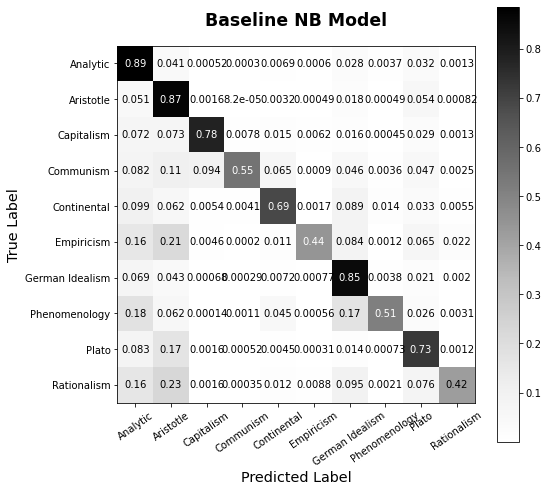

In [6]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [7]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.64      0.89      0.74     13433
      aristotle       0.61      0.87      0.72     12204
     capitalism       0.86      0.78      0.82      4483
      communism       0.96      0.55      0.70      4463
    continental       0.85      0.69      0.76      8475
     empiricism       0.95      0.44      0.60      5028
german_idealism       0.69      0.85      0.76     10370
  phenomenology       0.94      0.51      0.66      7168
          plato       0.71      0.73      0.72      9642
    rationalism       0.90      0.42      0.57      5769

       accuracy                           0.72     81035
      macro avg       0.81      0.67      0.71     81035
   weighted avg       0.77      0.72      0.71     81035



Accuracy in the low 70s over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [8]:
df['school'].value_counts(normalize=True)

analytic           0.164882
aristotle          0.150487
german_idealism    0.129996
plato              0.118440
continental        0.104217
phenomenology      0.088150
rationalism        0.070803
empiricism         0.061489
capitalism         0.056130
communism          0.055405
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence'], df['school'])

In [10]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [11]:
y_train, y_test, flipped_dict = class_weight_applier(y_train, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[4 1 4 ... 6 6 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Oversampling

In [12]:
ros = RandomOverSampler(sampling_strategy='all')

In [13]:
x_under, y_under = ros.fit_sample(tf_idf_data_train, y_train)

In [14]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

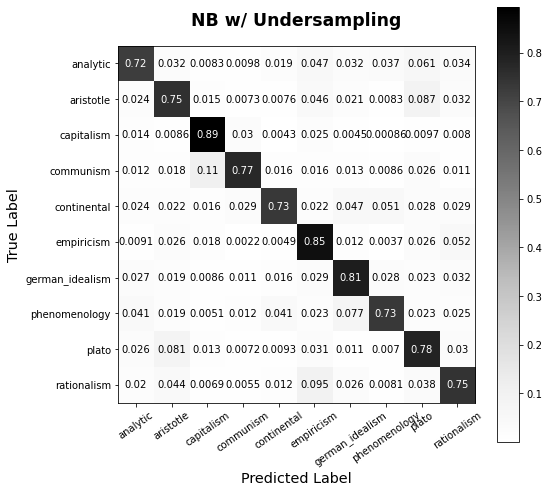

In [15]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [16]:
print(classification_report(y_test, nb_undersampled_preds))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78     13330
           1       0.81      0.75      0.78     12232
           2       0.76      0.89      0.82      4627
           3       0.79      0.77      0.78      4547
           4       0.85      0.73      0.79      8485
           5       0.59      0.85      0.70      4923
           6       0.81      0.81      0.81     10593
           7       0.78      0.73      0.75      7086
           8       0.71      0.78      0.75      9534
           9       0.65      0.75      0.70      5678

    accuracy                           0.77     81035
   macro avg       0.76      0.78      0.77     81035
weighted avg       0.78      0.77      0.77     81035



Not bad, we got a sold increase in accuracy. Let's check if oversampling helps any more.

#### Undersampling

In [17]:
rus = RandomUnderSampler(sampling_strategy='all')

In [18]:
x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

In [19]:
nb_oversampled = MultinomialNB()
nb_oversampled.fit(x_under, y_under)
nb_oversampled_preds = nb_oversampled.predict(tf_idf_data_test)

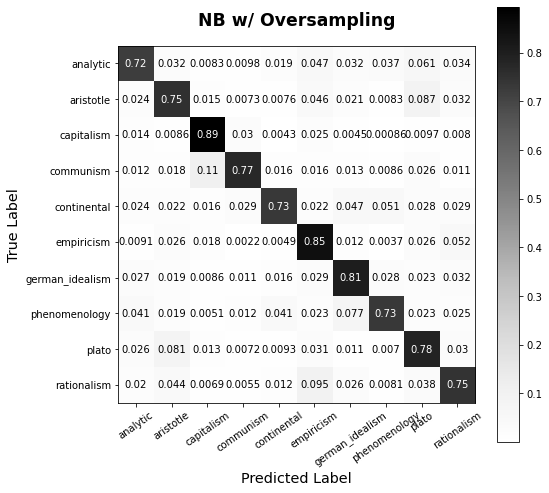

In [20]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Oversampling', label_dict=flipped_dict)

In [21]:
print(classification_report(y_test, nb_oversampled_preds))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78     13330
           1       0.81      0.75      0.78     12232
           2       0.76      0.89      0.82      4627
           3       0.79      0.77      0.78      4547
           4       0.85      0.73      0.79      8485
           5       0.59      0.85      0.70      4923
           6       0.81      0.81      0.81     10593
           7       0.78      0.73      0.75      7086
           8       0.71      0.78      0.75      9534
           9       0.65      0.75      0.70      5678

    accuracy                           0.77     81035
   macro avg       0.76      0.78      0.77     81035
weighted avg       0.78      0.77      0.77     81035



Unsurprisingly, not much of a different result. It seems like Multinomial Naive Bayes can give us about 77% accuracy. 

It's perhaps worth checking if lemmatization can help the model.

### NB with Lemmatization

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [23]:
y_train, y_test, flipped_dict = class_weight_applier(y_train, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[6 4 0 ... 0 0 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [24]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

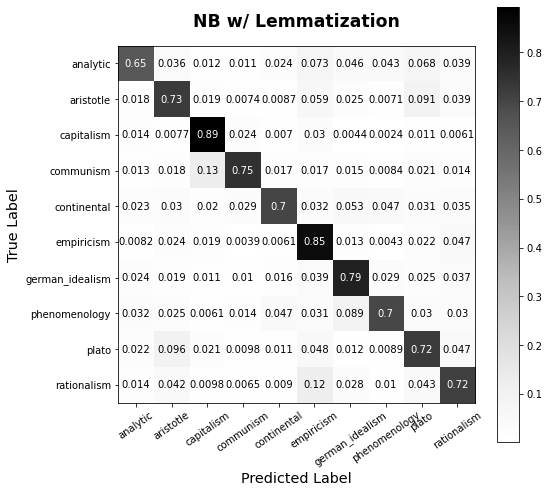

In [25]:
nb_lemma = MultinomialNB()
nb_lemma.fit(x_over_lemma, y_over_lemma)
nb_lemma_preds = nb_lemma.predict(tf_idf_data_test)

plot_pretty_cf(nb_lemma, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [26]:
print(classification_report(y_test, nb_lemma_preds))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74     13174
           1       0.78      0.73      0.75     12176
           2       0.71      0.89      0.79      4574
           3       0.78      0.75      0.76      4516
           4       0.83      0.70      0.76      8495
           5       0.51      0.85      0.64      4893
           6       0.77      0.79      0.78     10585
           7       0.76      0.70      0.73      7205
           8       0.68      0.72      0.70      9615
           9       0.61      0.72      0.66      5802

    accuracy                           0.73     81035
   macro avg       0.73      0.75      0.73     81035
weighted avg       0.75      0.73      0.74     81035



Not great, and worse than non-lemmatized versions. This makes sense since lemmatization essentially masks information that might have had some small part to play in the classification math.

### NB with Bigrams

While singular words may not always be indicative of a school, certain phrases are often almost entirely exclusive to a school. So it stands to reason that incorporating bigrams into our data would help the model.

In [27]:
# vectorize, this time adjusting the ngram range to include bigrams
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=[], 
                                 ngram_range=(1,2))
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [28]:
y_train, y_test, flipped_dict = class_weight_applier(y_train, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[6 4 0 ... 0 0 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [29]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_bgram, y_over_bgram = rus.fit_sample(tf_idf_data_train, y_train)

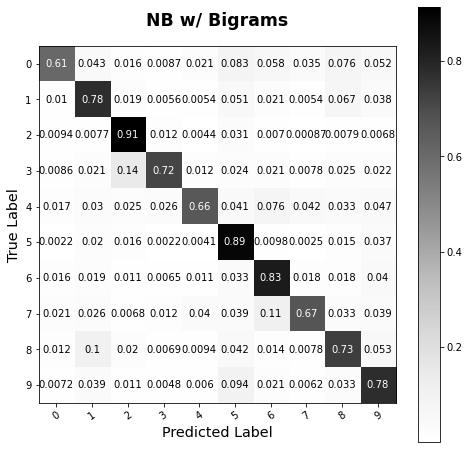

In [30]:
nb_bigrams = MultinomialNB()
nb_bigrams.fit(x_over_bgram, y_over_bgram)
nb_bigrams_preds = nb_bigrams.predict(tf_idf_data_test)

plot_pretty_cf(nb_bigrams, tf_idf_data_test, y_test, 
               title='NB w/ Bigrams', label_dict=flipped_dict)

In [31]:
print(classification_report(y_test, nb_bigrams_preds))

              precision    recall  f1-score   support

           0       0.90      0.61      0.73     13174
           1       0.78      0.78      0.78     12176
           2       0.70      0.91      0.79      4574
           3       0.82      0.72      0.76      4516
           4       0.85      0.66      0.74      8495
           5       0.53      0.89      0.66      4893
           6       0.75      0.83      0.79     10585
           7       0.80      0.67      0.73      7205
           8       0.71      0.73      0.72      9615
           9       0.60      0.78      0.67      5802

    accuracy                           0.74     81035
   macro avg       0.74      0.76      0.74     81035
weighted avg       0.77      0.74      0.74     81035



It seems like bigrams actually made the model worse. Let's try something totally different - random forests!

### Random Forest Classifier

Random Forests don't always do well on this kind of task, but it's perhaps worth trying. We'll just do an untuned model to see if it gets any kind of results worth exploring. 

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', 
                                 stop_words=[])
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

y_train, y_test, flipped_dict = class_weight_applier(y_train, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[6 4 0 ... 9 8 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [33]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

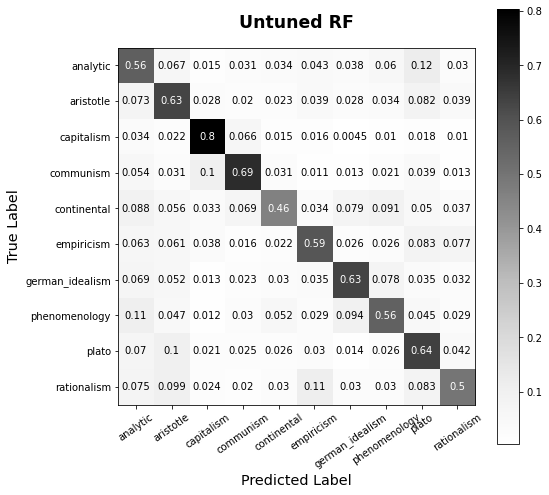

In [35]:
rf = RandomForestClassifier()
rf.fit(x_over, y_over)
rf_preds = rf.predict(tf_idf_data_test)

plot_pretty_cf(rf, tf_idf_data_test, y_test, 
               title='Untuned RF', label_dict=flipped_dict)

In [36]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58     13260
           1       0.64      0.63      0.64     12130
           2       0.64      0.80      0.71      4479
           3       0.56      0.69      0.62      4471
           4       0.64      0.46      0.54      8381
           5       0.49      0.59      0.54      4912
           6       0.71      0.63      0.67     10570
           7       0.53      0.56      0.54      7212
           8       0.56      0.64      0.60      9738
           9       0.53      0.50      0.51      5882

    accuracy                           0.60     81035
   macro avg       0.59      0.61      0.59     81035
weighted avg       0.60      0.60      0.60     81035



Unfortunately the random forest model got only 60%, worse than any Bayesian model. A result like this is poor enough that spending time refining it may just not be worth the effort, especially when there are more promising avenues still to explore. 

Overall, the Bayesian models were able to reach 77% accuracy when corrected for class imbalance. When one takes into account the number of classes (10) involved, that is a respectable result. 